In [ ]:
# Data Preprocessing and Uploading

# Uploading the files from personal drive
from google.colab import files
uploaded = files.upload()

Saving thick_regions.csv to thick_regions.csv


In [ ]:
# Using the h5py package for extracting the data in a usable format
import h5py
import numpy as np
mat_file = h5py.File("radiomics_data_freesurfer.mat", 'r')
mat_file_2 = h5py.File("radiomics_data_fastaid.mat", 'r')
mat_file_3 = h5py.File("thickness_data_fastaid.mat", 'r')
mat_file_4 = h5py.File("texture_data_freesurfer.mat", 'r')
mat_file_5 = h5py.File("deep_data_resnet3-50.mat", 'r')

# Sanity-check to ensure the above lines worked properly
# list(mat_file.keys())

In [ ]:
# Fitting logistic regression and decsion tree to just radio data

def model_radio(feature, unwanted_label, wanted_label,model):
  freesurfer_Xtrain = mat_file['XTrain'][feature,:,:]

  freesurfer_Xvalid = mat_file['XValid'][feature,:,:]

  freesurfer_Xtest = mat_file['XTest'][feature,:,:]

  fastaid_Xtrain = mat_file_2['XTrain'][feature,:,:]

  fastaid_Xvalid = mat_file_2['XValid'][feature,:,:]

  fastaid_Xtest = mat_file_2['XTest'][feature,:,:]

# normalization across volume
  test_sum = np.sum(fastaid_Xtest, axis=0, keepdims=True)
  train_sum = np.sum(fastaid_Xtrain, axis=0, keepdims=True)
  valid_sum = np.sum(fastaid_Xvalid, axis=0, keepdims=True)

  free_Xtrain_normal = (freesurfer_Xtrain / train_sum)
  free_Xtest_normal = (freesurfer_Xtest / test_sum)
  free_Xvalid_normal = (freesurfer_Xvalid / valid_sum)

  #Extract labels
  X_train = np.array(free_Xtrain_normal)
  Y_train = np.array(mat_file['TTrain'][:])
  X_test = np.array(free_Xtest_normal)
  Y_test = np.array(mat_file['TTest'][:])
  X_valid = np.array(free_Xvalid_normal)
  Y_valid = np.array(mat_file['TValid'][:])


  # Take out the Labels I am using
  Y_valid = Y_valid.flatten()
  X_valid = X_valid[:, (Y_valid != unwanted_label)]
  Y_valid = Y_valid[Y_valid != unwanted_label ]

  Y_test = Y_test.flatten()
  X_test = X_test[:, (Y_test != unwanted_label)]
  Y_test = Y_test[Y_test != unwanted_label ]

  Y_train = Y_train.flatten()
  X_train = X_train[:, (Y_train != unwanted_label)]
  Y_train = Y_train[Y_train != unwanted_label ]

  X_train = X_train.transpose()
  X_valid = X_valid.transpose()


  from sklearn.linear_model import LogisticRegression
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.model_selection import StratifiedKFold
  from sklearn.metrics import accuracy_score

  Y_train_binary = (Y_train == wanted_label).astype(int)  # Map 2 to 1 (positive class)
  Y_valid_binary = (Y_valid == wanted_label).astype(int)


  X = np.concatenate((X_train, X_valid), axis=0)
  Y = np.concatenate((Y_train_binary, Y_valid_binary), axis=0)
  print(Y)

# Initialize Stratified K-Fold Cross-Validator
  kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
  accuracy_scores = []
  train_accuracy_scores = []

  for train_index, valid_index in kfold.split(X, Y):
    # Split data into training and validation sets for this fold
    X_train_fold, X_valid_fold = X[train_index], X[valid_index]
    Y_train_fold, Y_valid_fold = Y[train_index], Y[valid_index]

    # Fit the model on training data for this fold
    model.fit(X_train_fold, Y_train_fold)

    # Predict on validation data for this fold
    Y_pred_fold = model.predict(X_valid_fold)
    Y_pred_train_fold = model.predict(X_train_fold)
    # Calculate accuracy for this fold
    accuracy = accuracy_score(Y_valid_fold, Y_pred_fold)
    accuracy_scores.append(accuracy)
    train_accuracy = accuracy_score(Y_train_fold, Y_pred_train_fold)
    train_accuracy_scores.append(train_accuracy)

  avg_accuracy = np.mean(accuracy_scores)
  avg_train_accuracy = np.mean(train_accuracy_scores)

  return train_accuracy, accuracy


In [ ]:
# Fitting logistic regression and decsion tree to just thickness data

def model_thick(feature, unwanted_label, wanted_label,model):
  thick_Xtrain = mat_file['XTrain'][feature,:,:]

  thick_Xvalid = mat_file['XValid'][feature,:,:]

  thick_Xtest = mat_file['XTest'][feature,:,:]

  #Extract labels
  X_train = np.array(thick_Xtrain)
  Y_train = np.array(mat_file['TTrain'][:])
  X_test = np.array(thick_Xtest)
  Y_test = np.array(mat_file['TTest'][:])
  X_valid = np.array(thick_Xvalid)
  Y_valid = np.array(mat_file['TValid'][:])


  # Take out the Labels I am using
  Y_valid = Y_valid.flatten()
  X_valid = X_valid[:, (Y_valid != unwanted_label)]
  Y_valid = Y_valid[Y_valid != unwanted_label ]

  Y_test = Y_test.flatten()
  X_test = X_test[:, (Y_test != unwanted_label)]
  Y_test = Y_test[Y_test != unwanted_label ]

  Y_train = Y_train.flatten()
  X_train = X_train[:, (Y_train != unwanted_label)]
  Y_train = Y_train[Y_train != unwanted_label ]

  X_train = X_train.transpose()
  X_valid = X_valid.transpose()


  from sklearn.linear_model import LogisticRegression
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.model_selection import StratifiedKFold
  from sklearn.metrics import accuracy_score

  Y_train_binary = (Y_train == wanted_label).astype(int)  # Map 2 to 1 (positive class)
  Y_valid_binary = (Y_valid == wanted_label).astype(int)


  X = np.concatenate((X_train, X_valid), axis=0)
  Y = np.concatenate((Y_train_binary, Y_valid_binary), axis=0)


# Initialize Stratified K-Fold Cross-Validator
  kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
  accuracy_scores = []
  train_accuracy_scores = []

  for train_index, valid_index in kfold.split(X, Y):
    # Split data into training and validation sets for this fold
    X_train_fold, X_valid_fold = X[train_index], X[valid_index]
    Y_train_fold, Y_valid_fold = Y[train_index], Y[valid_index]

    # Fit the model on training data for this fold
    model.fit(X_train_fold, Y_train_fold)

    # Predict on validation data for this fold
    Y_pred_fold = model.predict(X_valid_fold)
    Y_pred_train_fold = model.predict(X_train_fold)
    # Calculate accuracy for this fold
    accuracy = accuracy_score(Y_valid_fold, Y_pred_fold)
    accuracy_scores.append(accuracy)
    train_accuracy = accuracy_score(Y_train_fold, Y_pred_train_fold)
    train_accuracy_scores.append(train_accuracy)

  avg_accuracy = np.mean(accuracy_scores)
  avg_train_accuracy = np.mean(train_accuracy_scores)

  return train_accuracy, accuracy

In [ ]:
# Combining into one big dataset

#Step 1: Normalize fastaid volume and area


def radio_combine(feature, normal):
  fast_Xtrain = mat_file_2['XTrain'][feature,:,:]

  fast_Xvalid = mat_file_2['XValid'][feature,:,:]

  fast_Xtest = mat_file_2['XTest'][feature,:,:]
  if normal == True:
    # normalization across volume
    test_sum = np.sum(fast_Xtest, axis=0, keepdims=True)
    train_sum = np.sum(fast_Xtrain, axis=0, keepdims=True)
    valid_sum = np.sum(fast_Xvalid, axis=0, keepdims=True)
    fast_Xtrain = (fast_Xtrain / train_sum)
    fast_Xtest = (fast_Xtest / test_sum)
    fast_Xvalid = (fast_Xvalid / valid_sum)

  #extract labels
  X_train = np.array(fast_Xtrain)
  X_test = np.array(fast_Xtest)
  X_valid = np.array(fast_Xvalid)

  X_train = X_train.transpose()
  X_valid = X_valid.transpose()
  X = np.concatenate((X_train, X_valid), axis=0)
  return X

#Step 2: Concateneate fastaid valid and train files 132 x 11 = 1452 columns
radio = np.concatenate((radio_combine(0,True), radio_combine(1,True), radio_combine(2,False),radio_combine(3,False),radio_combine(4,False), radio_combine(5,False), radio_combine(6,False), radio_combine(7,False), radio_combine(8,False), radio_combine(9,False), radio_combine(10,False)), axis = 1)

def radio_test(feature, normal):


  fast_Xtest = mat_file_2['XTest'][feature,:,:]
  if normal == True:
    # normalization across volume
    test_sum = np.sum(fast_Xtest, axis=0, keepdims=True)
    fast_Xtest = (fast_Xtest / test_sum)

  #extract labels
  X_test = np.array(fast_Xtest).transpose()

  return X_test

radio_test = np.concatenate((radio_test(0,True), radio_test(1,True), radio_test(2,False),radio_test(3,False),radio_test(4,False), radio_test(5,False), radio_test(6,False), radio_test(7,False), radio_test(8,False), radio_test(9,False), radio_test(10,False)), axis = 1)



#X = np.concatenate((X_train, X_valid), axis=0)


In [ ]:
#Step 2: Concateneate thickess valid and train files 102 x 2 + 1452 = 1656 columns (fix names!)
thick_Xtrain = mat_file_3['XTrain'][0,:,:]

thick_Xvalid = mat_file_3['XValid'][0,:,:]

thick_Xtest = mat_file_3['XTest'][0,:,:]
X_train = np.array(thick_Xtrain)
X_valid = np.array(thick_Xvalid)
X_test_0 = np.array(thick_Xtest).transpose()

X_train = X_train.transpose()
X_valid = X_valid.transpose()
A = np.concatenate((X_train, X_valid), axis=0)
thick_Xtrain = mat_file_3['XTrain'][1,:,:]

thick_Xvalid = mat_file_3['XValid'][1,:,:]

thick_Xtest = mat_file_3['XTest'][1,:,:]
X_train = np.array(thick_Xtrain)
X_valid = np.array(thick_Xvalid)
X_test_1 = np.array(thick_Xtest).transpose()

X_train = X_train.transpose()
X_valid = X_valid.transpose()
B = np.concatenate((X_train, X_valid), axis=0)

C = np.concatenate((A, B), axis=1)

thick_test = np.concatenate((X_test_0, X_test_1), axis=1)
thick_test.shape

thick_radio = np.concatenate((radio, C), axis=1)
thick_radio.shape


(423, 1656)

In [ ]:
#Step 3: Concatenate texture valid and train files 300 x 90 + 1656 + 27,000 = 28,656 (fix names!)
def text_combine(feature):
  fast_Xtrain = mat_file_4['XTrain'][feature,:,:]

  fast_Xvalid = mat_file_4['XValid'][feature,:,:]

  fast_Xtest = mat_file_4['XTest'][feature,:,:]
  #extract labels
  X_train = np.array(fast_Xtrain)
  X_test = np.array(fast_Xtest)
  X_valid = np.array(fast_Xvalid)

  X_train = X_train.transpose()
  X_valid = X_valid.transpose()
  X = np.concatenate((X_train, X_valid), axis=0)
  return X


T = np.concatenate((text_combine(0), text_combine(1)), axis=1)
for i in range(2,90):
  T = np.concatenate((T, text_combine(i)), axis=1)

texture_test = np.concatenate((np.array(mat_file_4['XTest'][0,:,:]).transpose(), np.array(mat_file_4['XTest'][1,:,:]).transpose()), axis=1)
for i in range(2,90):
  texture_test = np.concatenate((texture_test, np.array(mat_file_4['XTest'][i,:,:]).transpose()), axis = 1)

In [ ]:
big_data_v1 = np.concatenate((thick_radio, T), axis=1)

In [ ]:
big_data_v1.shape

(423, 28656)

In [ ]:
# Step 4: Bringing resnet18 into the mix, first seperate into train/valid and test and concating all together
import pandas as pd
id_df = pd.read_csv("id_train.csv", header=None)
resnet_df = pd.read_csv("resnet_features_true.csv", header=None)

id_df.columns = ['ID']
merged_df = pd.merge(id_df, resnet_df, left_on='ID', right_on=resnet_df.columns[0], how='left')
merged_df = merged_df.drop(columns=[0])
merged_df = merged_df.drop(columns=["ID"])
big_data_all = np.concatenate((big_data_v1, merged_df), axis=1)

id_test = pd.read_csv("id_test.csv", header=None)
id_test.columns = ['ID']
resnet_test = pd.merge(id_test, resnet_df, left_on='ID', right_on=resnet_df.columns[0], how='left')
resnet_test = resnet_test.drop(columns=[0])
resnet_test = resnet_test.drop(columns=["ID"])

test_data = np.concatenate((radio_test, thick_test, texture_test, resnet_test), axis=1)

In [ ]:
# ALL + Sex & + Age
id_df = pd.read_csv("id_train.csv", header=None)
id_test_df = pd.read_csv("id_test.csv", header=None)
Sex_Age = pd.read_csv("Age_Sex.csv", header=None)
id_df.columns = ['ID']
all_sex_df = pd.merge(id_df, Sex_Age, left_on='ID', right_on=Sex_Age.columns[0], how='left')

age_df = np.array(all_sex_df)[:,2]
sex_df = np.array(all_sex_df)[:,3]

id_test_df.columns = ['ID']
all_sex_test_df = pd.merge(id_test_df, Sex_Age, left_on='ID', right_on=Sex_Age.columns[0], how='left')

age_test_df = np.array(all_sex_test_df)[:,2]
sex_test_df = np.array(all_sex_test_df)[:,3]

#big_data_all.shape
#age_df.shape

big_data_all = np.concatenate((big_data_all, age_df[:, None]), axis=1)
test_data = np.concatenate((radio_test, thick_test, texture_test, resnet_test, age_test_df[:, None]), axis=1)


In [ ]:
# Bringing resnet50 into the mix, first seperate into train/valid and test
import pandas as pd
import numpy as np

id_df = pd.read_csv("id_train.csv", header=None)
resnet50_df = pd.read_csv("resnet_50_feat.csv", header=None)

id_df.columns = ['ID']
merged50_df = pd.merge(id_df, resnet50_df, left_on='ID', right_on=resnet50_df.columns[0], how='left')
merged50_df = merged50_df.drop(columns=[0])
merged50_df = merged50_df.drop(columns=["ID"])
#big_data_all = np.concatenate((big_data_v1, merged_df), axis=1)

id_test = pd.read_csv("id_test.csv", header=None)
id_test.columns = ['ID']
resnet50_test = pd.merge(id_test, resnet50_df, left_on='ID', right_on=resnet50_df.columns[0], how='left')
resnet50_test = resnet50_test.drop(columns=[0])
resnet50_test = resnet50_test.drop(columns=["ID"])


In [ ]:
# Resnet3-50

mat_file_5 = h5py.File("deep_data_resnet3-50.mat", 'r')
res3_Xtrain = mat_file_5['XTrain'][0,:,:]

res3_Xvalid = mat_file_5['XValid'][0,:,:]

res3_Xtest = mat_file_5['XTest'][0,:,:]
res3_X_train = np.array(res3_Xtrain).transpose()
res3_X_valid = np.array(res3_Xvalid).transpose()

print(res3_X_train.shape)
print(res3_X_valid.shape)

res3_X_test = np.array(res3_Xtest).transpose()
res3_X = np.concatenate((res3_X_train, res3_X_valid), axis=0)

In [ ]:
#Uncomemnt lines depending on which subset of the data being used:
# big_data_all becomes training dataset where test_data becomes test dataset

# Resnet 18
#fix = np.array(merged_df)
#big_data_all = fix
#test_data = np.array(resnet_test)

# Texture
#big_data_all = T
#test_data = texture_test

# Thickness
# big_data_all = C
# test_data = thick_test

# Radio
#big_data_all = radio
#test_data = radio_test

# Radio and Thickness
#big_data_all = thick_radio
#test_data = np.concatenate((radio_test, thick_test), axis=1)

# Thickness and Texture
#big_data_all = np.concatenate((C, T), axis=1)
#test_data = np.concatenate((thick_test, texture_test), axis=1)

# Radio and Texture
#big_data_all = np.concatenate((radio, T), axis=1)
#test_data = np.concatenate((radio_test, texture_test), axis=1)

# Resnet50
#big_data_all = np.array(merged50_df)
#test_data = np.array(resnet50_test)

# Resnet3-50
#test_data = res3_X_test
#big_data_all = res3_X

In [ ]:
# Getting Labels and subsetting based on which level I'm using

# _mci means the data contains only the samples with mci or cn
# _ac means the data contains only the samples with ad or cn

Y_train = np.array(mat_file['TTrain'][:])
Y_valid = np.array(mat_file['TValid'][:])
Y_test = np.squeeze(np.array(mat_file['TTest'][:]))

Y_train = np.squeeze(np.concatenate((Y_train, Y_valid), axis=1))

test_data_advcn = test_data[Y_test != 3, :]
big_data_advcn = big_data_all[Y_train != 3, :]
big_data_cnvmci = big_data_all[Y_train != 1, :]
test_data_cnvmci = test_data[Y_test != 1, :]

Y_train_mci = Y_train[Y_train != 1]
Y_train_ac = Y_train[Y_train != 3]

Y_test_mci = Y_test[Y_test != 1]
Y_test_ac = Y_test[Y_test != 3]

Y_train_mci = (Y_train_mci == 3).astype(int)
Y_train_ac = (Y_train_ac == 1).astype(int)  # Map 1 to 1 (positive class)

Y_test_mci = (Y_test_mci == 3).astype(int)
Y_test_ac = (Y_test_ac == 1).astype(int)
print(big_data_advcn.shape)
print(test_data_advcn.shape)


(226, 29169)
(44, 29169)


Mean cross-validated accuracy: 0.739572192513369
Standard deviation of cross-validated accuracy: 0.05418249797429021
Mean cross-validated ROC AUC score: 0.803095238095238
Standard deviation of cross-validated ROC AUC score: 0.07361687821765348
Mean cross-validated precision: 0.764021268586486
Standard deviation of cross-validated precision: 0.09240819927207235
Mean cross-validated specificity: 0.6166666666666667
Standard deviation of cross-validated specificity: 0.16407854432400049
Mean cross-validated recall: 0.8271052631578947
Standard deviation of cross-validated recall: 0.07221323073039161


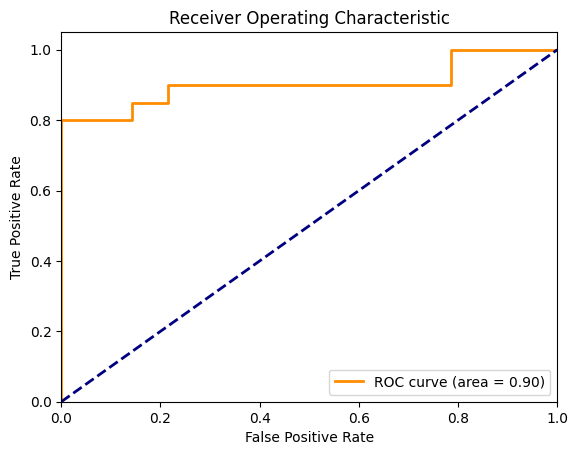

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

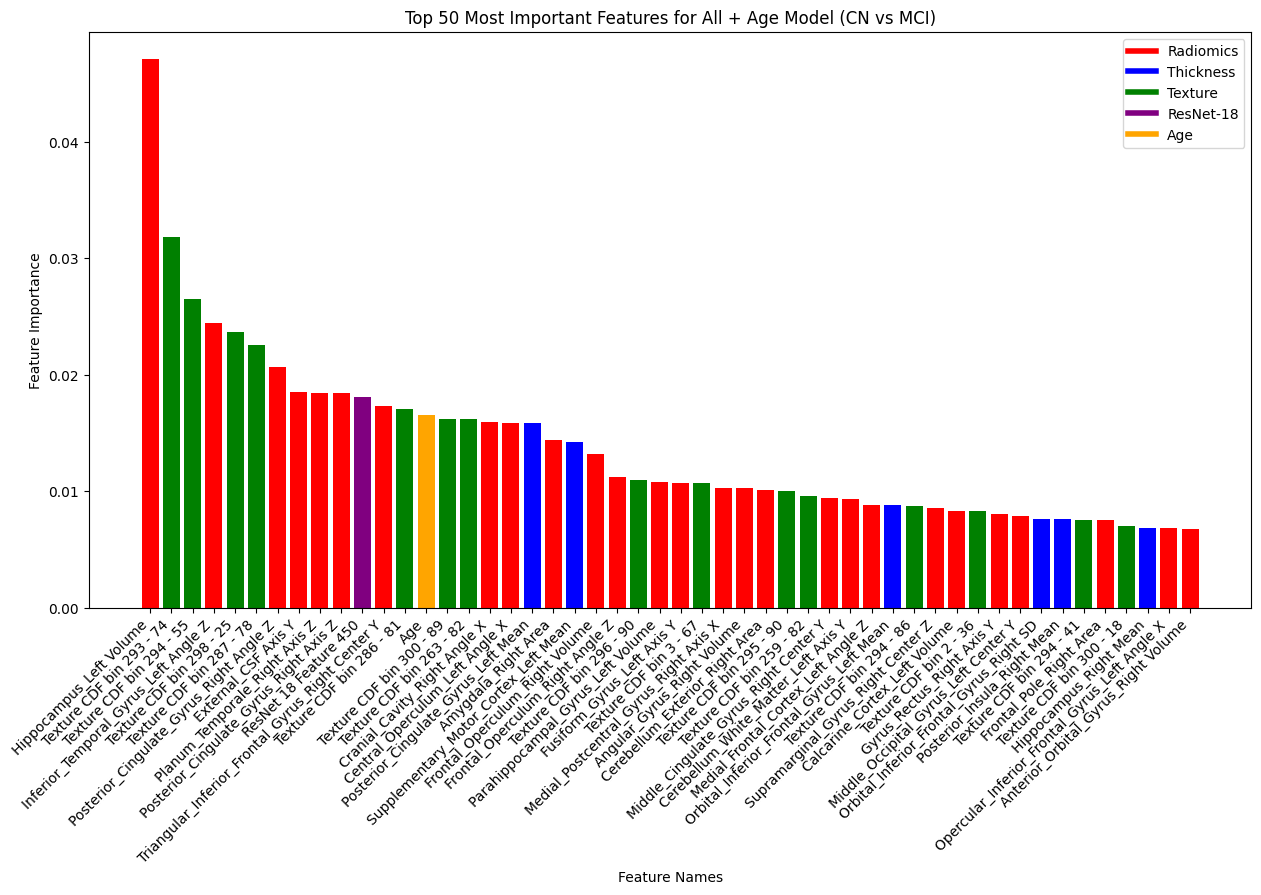

In [ ]:
# Fitting XGBoost

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_score, confusion_matrix, recall_score
import matplotlib.pyplot as plt
import numpy as np

X = big_data_cnvmci
y = Y_train_mci

# Initialize the XGBoost classifier with fixed parameters
xgb_clf = xgb.XGBClassifier(learning_rate= .3, max_depth= 3, n_estimators = 50,objective='binary:logistic', eval_metric='logloss', random_state=404)

 #Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 150]
}

# Initialize StratifiedKFold with a fixed random state for reproducibility
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=404)

# Initialize GridSearchCV with the classifier, parameter grid, and StratifiedKFold
#grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=kf, scoring='accuracy', n_jobs=-1, verbose=3)

# Fit GridSearchCV
#grid_search.fit(X, y)
#print("Best parameters found: ", grid_search.best_params_)
#best_xgb_clf = grid_search.best_estimator_
best_xgb_clf = xgb_clf

# Perform 10-fold cross-validation on the entire dataset with the best estimator
accuracy_scores = []
roc_auc_scores = []
precision_scores = []
specificity_scores = []
recall_scores = []

best_roc_auc = 0
best_model = None
best_fpr = None
best_tpr = None

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the best model
    best_xgb_clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = best_xgb_clf.predict(X_test)
    y_pred_proba = best_xgb_clf.predict_proba(X_test)[:, 1]

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    roc_auc_scores.append(roc_auc)

    # Calculate recall
    recall = recall_score(y_test, y_pred)
    recall_scores.append(recall)  # Store recall score

    # Calculate precision
    precision = precision_score(y_test, y_pred)
    precision_scores.append(precision)

    # Calculate specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    specificity_scores.append(specificity)

    # Update best model if current ROC AUC score is the best so far
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_model = best_xgb_clf
        best_fpr, best_tpr, _ = roc_curve(y_test, y_pred_proba)

# Calculate mean and standard deviation of accuracy scores
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
print(f"Mean cross-validated accuracy: {mean_accuracy}")
print(f"Standard deviation of cross-validated accuracy: {std_accuracy}")

# Calculate mean and standard deviation of ROC AUC scores
mean_roc_auc = np.mean(roc_auc_scores)
std_roc_auc = np.std(roc_auc_scores)
print(f"Mean cross-validated ROC AUC score: {mean_roc_auc}")
print(f"Standard deviation of cross-validated ROC AUC score: {std_roc_auc}")

# Calculate mean and standard deviation of precision scores
mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
print(f"Mean cross-validated precision: {mean_precision}")
print(f"Standard deviation of cross-validated precision: {std_precision}")

# Calculate mean and standard deviation of specificity scores
mean_specificity = np.mean(specificity_scores)
std_specificity = np.std(specificity_scores)
print(f"Mean cross-validated specificity: {mean_specificity}")
print(f"Standard deviation of cross-validated specificity: {std_specificity}")

#Recall
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
print(f"Mean cross-validated recall: {mean_recall}")
print(f"Standard deviation of cross-validated recall: {std_recall}")

# Plot ROC curve of the best model
plt.figure()
plt.plot(best_fpr, best_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {best_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


importance = best_model.feature_importances_

# Get the indices of the top 50 important features
top_50_indices = np.argsort(importance)[-50:]

# Get the importance percentages of the top 50 important features
top_50_importances = importance[top_50_indices]

feature_names = np.array(labels)
top_50_feature_names = feature_names[top_50_indices]

# Sort the top 50 features by importance in descending order
sorted_indices = np.argsort(top_50_importances)[::-1]
top_50_feature_names = top_50_feature_names[sorted_indices]
top_50_importances = top_50_importances[sorted_indices]
top_50_indices = top_50_indices[sorted_indices]

# Define color mapping based on index ranges
colors = []
for idx in top_50_indices:
    if 0 <= idx <= 1451:
        colors.append('red')
    elif 1452 <= idx <= 1655:
        colors.append('blue')
    elif 1656 <= idx <= 28655:
        colors.append('green')
    elif 28656 <= idx <= 29167:
        colors.append('purple')
    elif idx == 29168:
        colors.append('orange')
    else:
        colors.append('black')


# Plot histogram of the top 50 most important features
plt.figure(figsize=(15, 12))
plt.bar(top_50_feature_names, top_50_importances, color=colors)
plt.xticks(range(50), top_50_feature_names, rotation=45, ha='right')
plt.xlabel('Feature Names')
plt.ylabel('Feature Importance')
plt.title('Top 50 Most Important Features for All + Age Model (CN vs MCI)')


# Create a legend
legend_labels = ['Radiomics', 'Thickness', 'Texture', 'ResNet-18', 'Age']
legend_colors = ['red', 'blue', 'green', 'purple', 'orange']
patches = [plt.Line2D([0], [0], color=color, lw=4) for color in legend_colors]
plt.legend(patches, legend_labels, loc='upper right')
from google.colab import files
plt.subplots_adjust(bottom=0.4)

plt.savefig("mci.png", bbox_inches='tight')
files.download("mci.png")

plt.show()


In [ ]:
# Code for creating a graph with the ROC curves of various models
# The plotting_roc takes in the dataset and the hyperparmeters learning_rate, max_depth, and n_estimators, then fits xgboost finding the best ROC for the training data for the best of 10 folds
# Uncomment lines depending on which models are being plotted


#ROC Curve:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plotting_roc(data, lr, md, n):
  Y_train = np.array(mat_file['TTrain'][:])
  Y_valid = np.array(mat_file['TValid'][:])
  Y_train = np.squeeze(np.concatenate((Y_train, Y_valid), axis=1))
  bd = data
  bd = bd[Y_train != 3, :]

  Y_train_ac = Y_train[Y_train != 3]
  Y_train_ac = (Y_train_ac == 1).astype(int)
  X = bd
  y = Y_train_ac


  xgb_clf = xgb.XGBClassifier(learning_rate= lr, max_depth= md, n_estimators = n, objective='binary:logistic', eval_metric='logloss',
                              use_label_encoder=False, random_state=404)


  kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=404)

  roc_auc_scores = []
  best_roc_auc = 0
  best_model = None
  best_fpr = None
  best_tpr = None

  for train_index, test_index in kf.split(X, y):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

      # Fit the best model
      xgb_clf.fit(X_train, y_train)

      # Predict on the test set
      y_pred = xgb_clf.predict(X_test)
      y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

      # Calculate ROC AUC score
      roc_auc = roc_auc_score(y_test, y_pred_proba)
      roc_auc_scores.append(roc_auc)

      # Update best model if current ROC AUC score is the best so far
      if roc_auc > best_roc_auc:
          best_roc_auc = roc_auc
          best_model = xgb_clf
          best_fpr, best_tpr, _ = roc_curve(y_test, y_pred_proba)

  # Calculate mean and standard deviation of ROC AUC scores
  mean_roc_auc = np.mean(roc_auc_scores)
  std_roc_auc = np.std(roc_auc_scores)
  print(f"Mean cross-validated ROC AUC score: {mean_roc_auc}")
  print(f"Standard deviation of cross-validated ROC AUC score: {std_roc_auc}")

  return best_roc_auc, best_tpr, best_fpr





from scipy.interpolate import interp1d


# Assuming plotting_roc is defined elsewhere and works as expected

# Function to interpolate ROC curve
def smooth_roc_curve(fpr, tpr, num_points=1000):
    interpolated_fpr = np.linspace(0, 1, num_points)
    interp_tpr = interp1d(fpr, tpr, kind='linear')
    interpolated_tpr = interp_tpr(interpolated_fpr)
    return interpolated_fpr, interpolated_tpr

# Sample data from plotting_roc function (replace with actual data)
best_roc_auc_all, best_tpr_all, best_fpr_all = plotting_roc(np.concatenate((big_data_v1, merged_df), axis=1), test_data, 0.1, 2, 50)
best_roc_auc_all_age, best_tpr_all_age, best_fpr_all_age = plotting_roc(np.concatenate((big_data_v1, merged_df, age_test_df, age_df[:, None]), axis=1), 0.1, 2, 50)
best_roc_auc_all_sex, best_tpr_all_sex, best_fpr_all_sex = plotting_roc(np.concatenate((big_data_v1, merged_df, sex_test_df, sex_df[:, None]), axis=1), 0.1, 2, 50)
#best_roc_auc_radio, best_tpr_radio, best_fpr_radio = plotting_roc(radio, 0.1, 4, 150)
#best_roc_auc_thick, best_tpr_thick, best_fpr_thick = plotting_roc(C, 0.3, 3, 50)
#best_roc_auc_tex, best_tpr_tex, best_fpr_tex = plotting_roc(T, 0.01, 2, 150)
#best_roc_auc_res18, best_tpr_res18, best_fpr_res18 = plotting_roc(np.array(merged_df), 0.1, 2, 150)
#best_roc_auc_res50, best_tpr_res50, best_fpr_res50 = plotting_roc(np.array(merged50_df), 0.01, 3, 50)
#best_roc_auc_res3_50, best_tpr_res3_50, best_fpr_res3_50 = plotting_roc(res3_X, 0.01, 3, 50)

#best_roc_auc_thick_rad, best_tpr_thick_rad, best_fpr_thick_rad = plotting_roc(thick_radio, 0.3, 4, 100)
#best_roc_aucthick_tex, best_tpr_thick_tex, best_fpr_thick_tex = plotting_roc(np.concatenate((C, T), axis=1), 0.01, 3, 100)
#best_roc_auc_rad_tex, best_tpr_rad_tex, best_fpr_rad_tex = plotting_roc(np.concatenate((radio, T), axis=1), 0.1, 2, 50)



# Plot the ROC curves
plt.figure()

# Plot each ROC curve
plt.plot(best_fpr_all, best_tpr_all, label=f'All (AUC = {best_roc_auc_all:.2f})')
plt.plot(best_fpr_all_age, best_tpr_all_age, label=f'All + Age (AUC = {best_roc_auc_all_age:.2f})')
#plt.plot(best_fpr_all_sex, best_tpr_all_sex, label=f'All + Sex (AUC = {best_roc_auc_all_sex:.2f})')
#plt.plot(best_fpr_radio, best_tpr_radio, label=f'Radiomics (AUC = {best_roc_auc_radio:.2f})')
#plt.plot(best_fpr_thick, best_tpr_thick, label=f'Thickness (AUC = {best_roc_auc_thick:.2f})')
#plt.plot(best_fpr_tex, best_tpr_tex, label=f'Texture (AUC = {best_roc_auc_tex:.2f})')
#plt.plot(best_fpr_res18, best_tpr_res18, label=f'ResNet-18 (AUC = {best_roc_auc_res18:.2f})')
#plt.plot(best_fpr_res50, best_tpr_res50, label=f'Resnet 50 (AUC = {best_roc_auc_res50:.2f})')
#plt.plot(best_fpr_res3_50, best_tpr_res3_50, label=f'Resnet3-50 (AUC = {best_roc_auc_res3_50:.2f})')
#plt.plot(best_fpr_thick_rad, best_tpr_thick_rad, label=f'Thick/Radio (AUC = {best_roc_auc_thick_rad:.2f})')
#plt.plot(best_fpr_thick_tex, best_tpr_thick_tex, label=f'Thick/Texture (AUC = {best_roc_aucthick_tex:.2f})')
#plt.plot(best_fpr_rad_tex, best_tpr_rad_tex, label=f'Radio/Texture (AUC = {best_roc_auc_rad_tex:.2f})')
# Plot the chance line
plt.plot([0, 1], [0, 1], 'k--')

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='best')



# Show plot
plt.show()

TypeError: plotting_roc() takes 4 positional arguments but 5 were given

In [ ]:
# Getting Metric Performance on Test data AD v CN

X_train = big_data_advcn
y_train = Y_train_ac
X_test = test_data_advcn
y_test = Y_test_ac


xgb_clf = xgb.XGBClassifier(learning_rate= .1, max_depth= 2, n_estimators = 50, objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=404)

xgb_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_clf.predict(X_test)
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Roc AUC: {roc_auc}")

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# Calculate specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
print(f"Specificity: {specificity}")

recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")


Accuracy: 0.8181818181818182
Roc AUC: 0.875
Precision: 0.8333333333333334
Specificity: 0.9285714285714286
Recall: 0.625


In [ ]:
# Getting Metric Performance on Test data CN v MCI

X_train = big_data_cnvmci
y_train = Y_train_mci
X_test = test_data_cnvmci
y_test = Y_test_mci


xgb_clf = xgb.XGBClassifier(learning_rate= .3, max_depth= 3, n_estimators = 50, objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=404)

xgb_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_clf.predict(X_test)
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Roc AUC: {roc_auc}")

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# Calculate specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
print(f"Specificity: {specificity}")

recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")


Accuracy: 0.671875
Roc AUC: 0.6736111111111112
Precision: 0.6829268292682927
Specificity: 0.5357142857142857
Recall: 0.7777777777777778


(80,)
(80, 29168)
(338, 29168)
(338,)
(64,)
(64, 29168)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:54:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Roc AUC: 0.6736111111111112
(80,)
(80, 29169)
(338, 29169)
(338,)
(64,)
(64, 29169)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:55:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Roc AUC: 0.7232142857142857
(80,)
(80, 1452)
(338, 1452)
(338,)
(64,)
(64, 1452)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:55:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Roc AUC: 0.6984126984126985
(80,)
(80, 204)
(338, 204)
(338,)
(64,)
(64, 204)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:55:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Roc AUC: 0.5337301587301587
(80,)
(80, 27000)
(338, 27000)
(338,)
(64,)
(64, 27000)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:55:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Roc AUC: 0.7172619047619048
(80,)
(80, 512)
(338, 512)
(338,)
(64,)
(64, 512)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:56:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Roc AUC: 0.42559523809523814


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

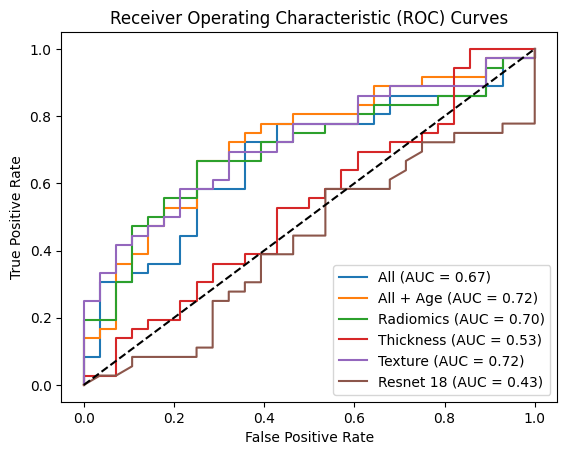

In [ ]:
# Test Roc Curves (same as above for the training data but for the test data)

#ROC Curve:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plotting_roc(data_train, data_test, lr, md, n):
# Prepare training data
  Y_train = np.array(mat_file['TTrain'][:])
  Y_valid = np.array(mat_file['TValid'][:])
  Y_train = np.squeeze(np.concatenate((Y_train, Y_valid), axis=1))

    # Exclude class '3' and convert to binary classification
  X_train = data_train[Y_train != 1, :]
  Y_train = Y_train[Y_train != 1]
  y_train = (Y_train == 3).astype(int)

    # Prepare test data
  Y_test = np.squeeze(np.array(mat_file['TTest'][:]))
  print(Y_test.shape)
  print(data_test.shape)
  X_test = data_test[Y_test != 1, :]
  Y_test = Y_test[Y_test != 1]
  y_test = (Y_test == 3).astype(int)


  print(X_train.shape)
  print(y_train.shape)
  print(y_test.shape)
  print(X_test.shape)

  xgb_clf = xgb.XGBClassifier(learning_rate= lr, max_depth= md, n_estimators = n, objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=404)

  xgb_clf.fit(X_train, y_train)

  # Predict on the test set
  y_pred = xgb_clf.predict(X_test)
  y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

  # Calculate ROC AUC score
  roc_auc = roc_auc_score(y_test, y_pred_proba)
  print(f"Roc AUC: {roc_auc}")

  fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

  return roc_auc, tpr, fpr




# Sample data from plotting_roc function (replace with actual data)
best_roc_auc_all, best_tpr_all, best_fpr_all = plotting_roc(np.concatenate((big_data_v1, merged_df), axis=1), test_data, 0.3, 3, 50)
best_roc_auc_all_age, best_tpr_all_age, best_fpr_all_age = plotting_roc(np.concatenate((big_data_v1, merged_df, age_df[:, None]), axis=1), np.concatenate((radio_test, thick_test, texture_test, resnet_test, age_test_df[:, None]), axis=1), 0.3, 3, 50)
#best_roc_auc_all_sex, best_tpr_all_sex, best_fpr_all_sex = plotting_roc(np.concatenate((big_data_v1, merged_df, sex_df[:, None]), axis=1), np.concatenate((radio_test, thick_test, texture_test, resnet_test, sex_test_df[:, None]), axis=1), 0.3, 3, 50)
best_roc_auc_radio, best_tpr_radio, best_fpr_radio = plotting_roc(radio, radio_test, 0.1, 4, 150)
best_roc_auc_thick, best_tpr_thick, best_fpr_thick = plotting_roc(C,thick_test, 0.3, 3, 50)
best_roc_auc_tex, best_tpr_tex, best_fpr_tex = plotting_roc(T, texture_test, 0.01, 2, 150)
best_roc_auc_res18, best_tpr_res18, best_fpr_res18 = plotting_roc(np.array(merged_df), np.array(resnet_test), 0.01, 2, 50)
#best_roc_auc_res50, best_tpr_res50, best_fpr_res50 = plotting_roc(np.array(merged50_df), np.array(resnet50_test), 0.01, 3, 50)
#best_roc_auc_res3_50, best_tpr_res3_50, best_fpr_res3_50 = plotting_roc(res3_X, res3_X_test, 0.01, 3, 50)

#best_roc_auc_thick_rad, best_tpr_thick_rad, best_fpr_thick_rad = plotting_roc(thick_radio, 0.3, 4, 100)
#best_roc_aucthick_tex, best_tpr_thick_tex, best_fpr_thick_tex = plotting_roc(np.concatenate((C, T), axis=1), 0.01, 3, 100)
#best_roc_auc_rad_tex, best_tpr_rad_tex, best_fpr_rad_tex = plotting_roc(np.concatenate((radio, T), axis=1), 0.1, 2, 50)



# Plot the ROC curves
plt.figure()

# Plot each ROC curve
plt.plot(best_fpr_all, best_tpr_all, label=f'All (AUC = {best_roc_auc_all:.2f})')
plt.plot(best_fpr_all_age, best_tpr_all_age, label=f'All + Age (AUC = {best_roc_auc_all_age:.2f})')
#plt.plot(best_fpr_all_sex, best_tpr_all_sex, label=f'All + Sex (AUC = {best_roc_auc_all_sex:.2f})')
plt.plot(best_fpr_radio, best_tpr_radio, label=f'Radiomics (AUC = {best_roc_auc_radio:.2f})')
plt.plot(best_fpr_thick, best_tpr_thick, label=f'Thickness (AUC = {best_roc_auc_thick:.2f})')
plt.plot(best_fpr_tex, best_tpr_tex, label=f'Texture (AUC = {best_roc_auc_tex:.2f})')
plt.plot(best_fpr_res18, best_tpr_res18, label=f'Resnet 18 (AUC = {best_roc_auc_res18:.2f})')
#plt.plot(best_fpr_res50, best_tpr_res50, label=f'Resnet 50 (AUC = {best_roc_auc_res50:.2f})')
#plt.plot(best_fpr_res3_50, best_tpr_res3_50, label=f'Resnet3-50 (AUC = {best_roc_auc_res3_50:.2f})')
#plt.plot(best_fpr_thick_rad, best_tpr_thick_rad, label=f'Thick/Radio (AUC = {best_roc_auc_thick_rad:.2f})')
#plt.plot(best_fpr_thick_tex, best_tpr_thick_tex, label=f'Thick/Texture (AUC = {best_roc_aucthick_tex:.2f})')
#plt.plot(best_fpr_rad_tex, best_tpr_rad_tex, label=f'Radio/Texture (AUC = {best_roc_auc_rad_tex:.2f})')
# Plot the chance line
plt.plot([0, 1], [0, 1], 'k--')

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='best')

from google.colab import files

plt.savefig("roc_mci.png", bbox_inches='tight')
files.download("roc_mci.png")

# Show plot
plt.show()

In [ ]:
# Creating an array with all the labels


#Radio labels
radio_labels = []
radio_labels = np.array(radio_labels)
radio_features = [" Volume", " Area", " Center X", " Center Y", " Center Z", " Angle X", " Angle Y", " Angle Z", " Axis X", " Axis Y", " Axis Z"]
radio_regions = np.array(pd.read_csv("radio_regions.csv", header=None))
for i in radio_features:
  for j in radio_regions:
    radio_labels = np.append(radio_labels, j + i)


#Thickness labels
thick_labels = []
thick_labels = np.array(thick_labels)
thick_features = [" Mean", " SD"]
thick_regions = np.array(pd.read_csv("thick_regions.csv", header=None))
for i in thick_features:
  for j in thick_regions:
    thick_labels = np.append(thick_labels, j + i)

#Texture labels
texture_labels = []
texture_labels = np.array(texture_labels)
texture_feature = range(1,301)
for i in range(1,91):
  for j in texture_feature:
    texture_labels = np.append(texture_labels, "Texture CDF bin " + str(j) +" - " + str(i))

resnet_labels = []
resnet_labels = np.array(resnet_labels)
resnet_features = range(1,513)
for i in resnet_features:
  resnet_labels = np.append(resnet_labels, "ResNet 18 Feature " + str(i))

resnet_age_labels = np.append(resnet_labels,"Age")

labels = np.concatenate((radio_labels, thick_labels, texture_labels, resnet_age_labels))
labels.shape


(29169,)

In [ ]:
# For finding the mean and standard deviation of various model metrics

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix
import numpy as np

# Your data
X = big_data_cnvmci
y = Y_train_mci
X_test = test_data_cnvmci
y_test = Y_test_mci

# Best hyperparameters from previous calculations
best_params = {
    'learning_rate': 0.3,
    'max_depth': 3,
    'n_estimators': 50,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 404
}

# Initialize the XGBoost classifier with the best parameters
best_xgb_clf = xgb.XGBClassifier(**best_params)

# Initialize StratifiedKFold with a fixed random state for reproducibility
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=404)

# Metrics for each fold
accuracy_scores = []
roc_auc_scores = []
precision_scores = []
specificity_scores = []
recall_scores = []

# Perform 10-fold cross-validation
for train_index, val_index in kf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Fit the model
    best_xgb_clf.fit(X_train, y_train)

    # Predict on the fixed test set
    y_test_pred = best_xgb_clf.predict(X_test)
    y_test_pred_proba = best_xgb_clf.predict_proba(X_test)[:, 1]

    # Calculate metrics for the test set
    accuracy = accuracy_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred_proba)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    specificity = tn / (tn + fp)

    # Append metrics to lists
    accuracy_scores.append(accuracy)
    roc_auc_scores.append(roc_auc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    specificity_scores.append(specificity)

# Calculate mean and standard deviation of the test metrics
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
mean_roc_auc = np.mean(roc_auc_scores)
std_roc_auc = np.std(roc_auc_scores)
mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
mean_specificity = np.mean(specificity_scores)
std_specificity = np.std(specificity_scores)

print(f"Mean test accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Mean test ROC AUC score: {mean_roc_auc:.4f} ± {std_roc_auc:.4f}")
print(f"Mean test precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Mean test recall: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"Mean test specificity: {mean_specificity:.4f} ± {std_specificity:.4f}")


Mean test accuracy: 0.6156 ± 0.0314
Mean test ROC AUC score: 0.6688 ± 0.0215
Mean test precision: 0.6331 ± 0.0252
Mean test recall: 0.7556 ± 0.0389
Mean test specificity: 0.4357 ± 0.0571
